<a href="https://colab.research.google.com/github/drummerviswa/python/blob/main/DWM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ITC Stock Price Prediction Using LSTM

## Import Libraries and Upload Dataset


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Load the dataset
df = pd.read_csv('ITC.csv')

Upload the ITC.csv file


Saving ITC.csv to ITC (2).csv


## Data Preprocessing

In [ ]:
# Convert Date column to datetime and handle numeric conversions
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

df['LOW'] = pd.to_numeric(df['LOW'], errors='coerce')
df['OPEN'] = pd.to_numeric(df['OPEN'], errors='coerce')
df['HIGH'] = pd.to_numeric(df['HIGH'], errors='coerce')
df['close'] = pd.to_numeric(df['close'], errors='coerce')

# Drop missing values
df.dropna(inplace=True)

# Extract and scale close prices
close_prices = df[['close']].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

## Create Data for LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def create_lstm_data(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_lstm_data(scaled_data, time_step)

# Reshape data for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Build and Train LSTM Model

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0381
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0024
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0022
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0019
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0021
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0021
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0020
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.0019
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0017
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 0.0016
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0015
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0014
Epoch 13/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0015
Epoch 14/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0015
Epoch 15/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - 

## Evaluate Model

In [ ]:
# Make predictions
test_predictions = model.predict(X_test)
test_predictions_rescaled = scaler.inverse_transform(test_predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAPE
mape = np.mean(np.abs((y_test_rescaled - test_predictions_rescaled) / y_test_rescaled)) * 100
print("LSTM Model MAPE:", mape, "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
LSTM Model MAPE: 1.1488241864151094 %


## Predict Next 5 Days

In [ ]:
def predict_next_days(model, last_sequence, days_to_predict=5):
    predictions = []
    input_sequence = last_sequence

    for _ in range(days_to_predict):
        prediction = model.predict(input_sequence.reshape(1, -1, 1))
        predictions.append(prediction[0, 0])
        input_sequence = np.append(input_sequence[1:], prediction)
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

last_sequence = scaled_data[-time_step:]
next_5_days = predict_next_days(model, last_sequence)

print("Predicted prices for the next 5 days:")
print(next_5_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted prices for the next 5 days:
[[417.66928]
 [419.2484 ]
 [419.74988]
 [420.25092]
 [420.97235]]


## Visualization

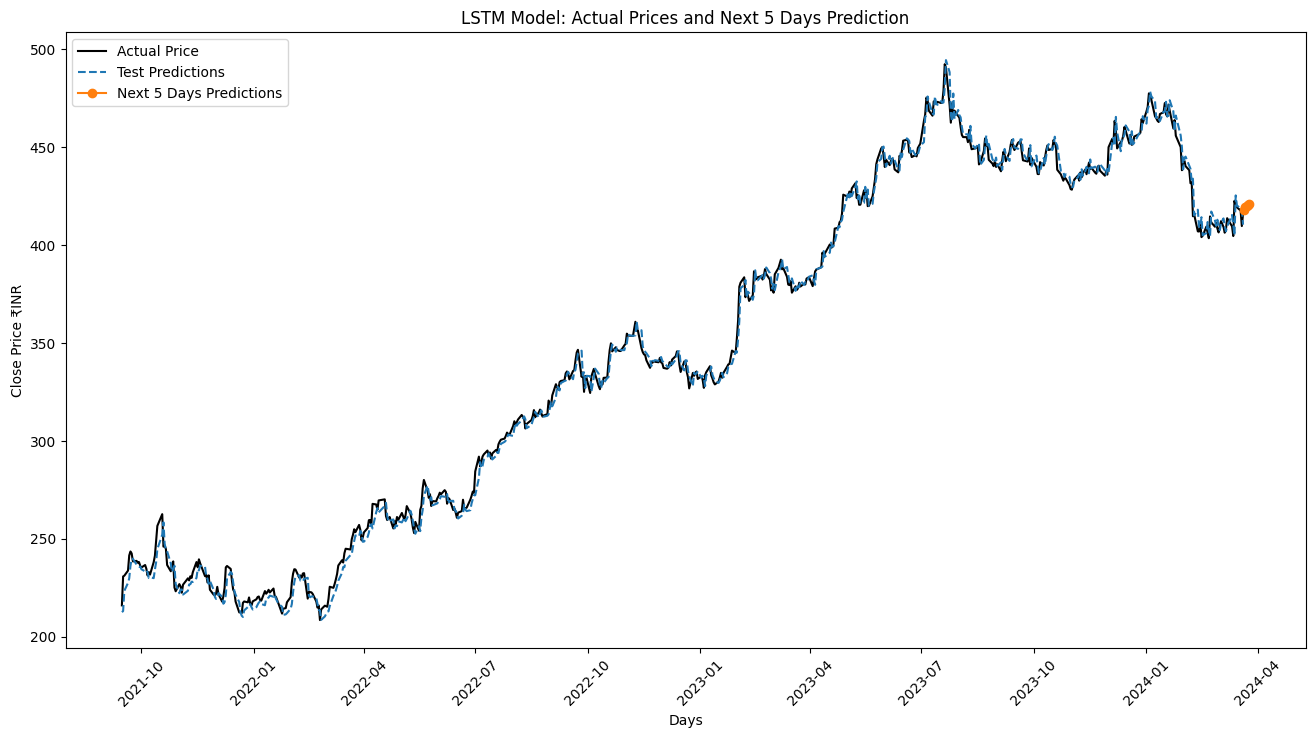

In [ ]:
# Plot results
plt.figure(figsize=(16, 8))
plt.title('LSTM Model: Actual Prices and Next 5 Days Prediction')
plt.xlabel('Days')
plt.ylabel('Close Price ₹INR')

plt.plot(df['Date'][-len(y_test):], y_test_rescaled, label='Actual Price', color='black')

plt.plot(df['Date'][-len(y_test):], test_predictions_rescaled, label='Test Predictions', linestyle='--')

future_dates = pd.date_range(df['Date'].iloc[-1], periods=6)[1:]
plt.plot(future_dates, next_5_days, label='Next 5 Days Predictions', marker='o')

plt.legend()
plt.xticks(rotation=45)
plt.show()